### Get the files

In [2]:
import os

img_paths = []
for root, dirs, files in os.walk("./history/"):
    for file in files:
        # Only images (png, jpg, jpeg)
        if file.endswith(".png") or file.endswith(".jpg"):
            img_paths.append(os.path.join(root, file))

### Load the model

In [3]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

### Get the encoded features

In [16]:
import torch
import numpy as np

from tqdm.notebook import tqdm
from PIL import Image

# Check if encoded features file exists
encoded_features_file = "encoded_features.pt"
if os.path.exists(encoded_features_file):
    # Load encoded features from file
    encoded_features = torch.load(encoded_features_file)
else:
    # Create the query
    from tqdm.notebook import tqdm

    # Process the image in batches
    batch_size = 32
    encoded_features = []
    model.to(device)
    for i in tqdm(range(0, len(img_paths), batch_size)):
        batch_paths = img_paths[i:i+batch_size]
        batch_images = []
        
        for img_path in batch_paths:
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
            batch_images.append(image)
        
        batch_images = torch.cat(batch_images)
        with torch.no_grad():
            batch_features = model.encode_image(batch_images)
        encoded_features.append(batch_features)
        tqdm.write(f"Processed batch: {i//batch_size + 1}")

        # Clear GPU memory
        del batch_images, batch_features
        torch.cuda.empty_cache()

    # Concatenate encoded features
    encoded_features = torch.cat(encoded_features, dim=0)

    # Save encoded features to file
    torch.save(encoded_features, encoded_features_file)

### Encode the query

In [26]:
# ⚠️❗ℹ️ Change this to whatever you want to search for
query = ["star wars"]

# Encode the text query
text = clip.tokenize(query).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)

### Compute cosine similarity

In [62]:
import numpy as np
similarities = torch.cosine_similarity(text_features, encoded_features).cpu().numpy()

### Find the most similar images

In [63]:
import numpy as np
n = 5
top_n = sorted(list(zip(img_paths, similarities)), key=lambda x: x[1], reverse=True)[:n]
bottom_n = sorted(list(zip(img_paths, similarities)), key=lambda x: x[1])[:n]

### Get the image paths

In [64]:
top_n_paths, top_n_probs = zip(*top_n)
bottom_n_paths, bottom_n_probs = zip(*bottom_n)

### Display the images


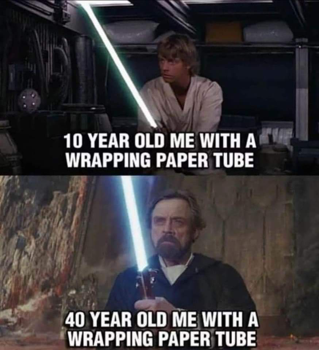
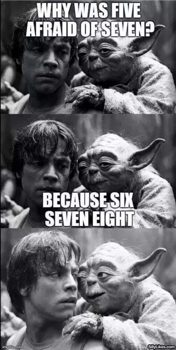
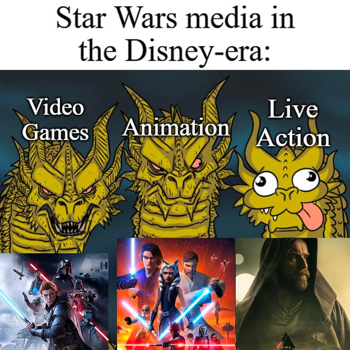
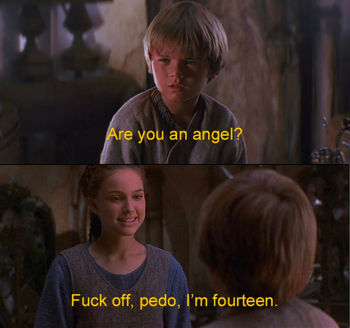
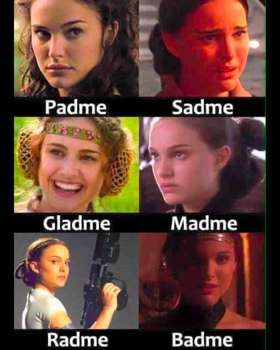


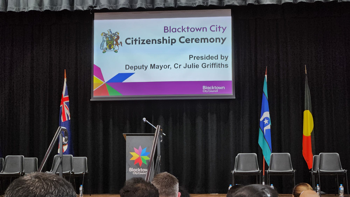
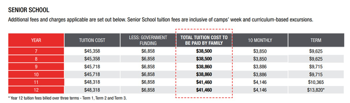
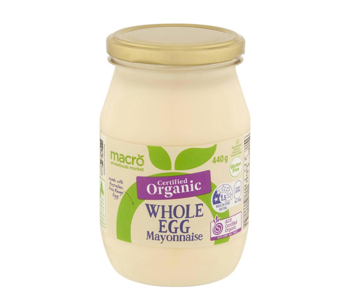
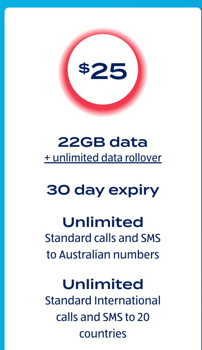
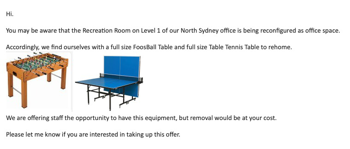

In [65]:
import io
import base64
from IPython.display import display, HTML

def display_images(image_paths, labels=None, header=None, thumbnail_size=(350, 350)):
    encoded_thumbnails = []
    
    for image_path in image_paths:
        with Image.open(image_path) as img:
            img.thumbnail(thumbnail_size)
            buffer = io.BytesIO()
            img.save(buffer, format='PNG')
            encoded_thumbnail = base64.b64encode(buffer.getvalue()).decode('utf-8')
            encoded_thumbnails.append(encoded_thumbnail)
    
    html = '''
    <style>
        .image-container {
            display: flex;
            flex-wrap: wrap;
        }
        .image-item {
            width: {thumbnail_size[0]}px;
            margin-right: 5px;
            margin-bottom: 5px;
            text-align: center;
        }
        .image-wrapper {
            width: {thumbnail_size[0]}px;
            height: {thumbnail_size[1]}px;
            display: flex;
            align-items: center;
            justify-content: center;
        }
        .image-wrapper img {
            max-width: 100%;
            max-height: 100%;
            object-fit: contain;
        }
        .image-label {
            font-size: 12px;
            margin-top: 5px;
        }
        .section-header {
            font-size: 18px;
            font-weight: bold;
            margin-bottom: 10px;
        }
    </style>
    '''
    
    if header:
        html += f'<div class="section-header"><h2>{header}<h2></div>'
    
    html += '<div class="image-container">'
    
    image_items = [
        f'''
        <div class="image-item">
            <div class="image-wrapper">
                <img src="data:image/png;base64,{encoded_thumbnail}">
            </div>
            <div class="image-label">{label if label else ""}</div>
        </div>
        '''
        for encoded_thumbnail, label in zip(encoded_thumbnails, labels if labels else [""]*len(encoded_thumbnails))
    ]
    
    html += ''.join(image_items)
    html += '</div>'
    
    display(HTML(html))

display_images(top_n_paths, labels=[f"Top-5: {np.sum(p):.2f}" for p in top_n_probs], header="Top 5 Images")
display_images(bottom_n_paths, labels=[f"Bottom-5: {np.sum(p):.2f}" for p in bottom_n_probs], header="Bottom 5 Images")